This notebooks is modified based on the AESPM tutorial linked here: https://github.com/RichardLiuCoding/aespm/tree/main/aespm/notebooks

In this notebook, I have changed all the AESPM functions to their equivalent ones in the RePySPM library.

It seems that the moving X and Y positions of the probe within a scan frame is currently missing in the library (something like point and shoot the probe). Currently I have placed a placeholder in the last cell as :

```Python
afm.scan_control.moveX(x_next)
afm.scan_control.moveY(y_next)
```

# Load packages

In [1]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import cv2

# import aespm as ae
from afm_controller import AFMController


In [2]:
# Step 1: Initialize the AFM Controller
afm = AFMController()

# Step 2: Connect to the AFM system
afm.connect()

# Acquire a topography map

In [ ]:
# Step 4: Set scan parameters
# Please skip this step if you prefer setting the initial parameters manually 
print("\n--- Setting Scan Parameters ---")
afm.scan_parameters.set_scan_parameters(
    width=10e-6,  # 10 µm
    height=10e-6, # 10 µm
    rotation=0,
    speed=1e-6    # 1 µm/s
)
print("Scan parameters set.")

In [ ]:
# Start a new scan and wait until it's done

print("\n--- Starting Scan ---")
afm.scan_control.scan_up()
print("Scanning upwards...")

In [ ]:
# You can either wait for a fixed time, or check if the scan is done every 10 sec

# # Method 1:
# time.sleep(240) # 4 min

# Method 2:
max_wait = 5 * 60 # let's wait no longer than 5 min
N = 0

while afm.scan_control.is_scanning() and N <= int(max_wait / 10):
    time.sleep(10)
    N += 1

In [ ]:
# Read the topography data from the controller or the saved image file

img = afm.image.get_channel("Topography")

# Extract all the edge pixels

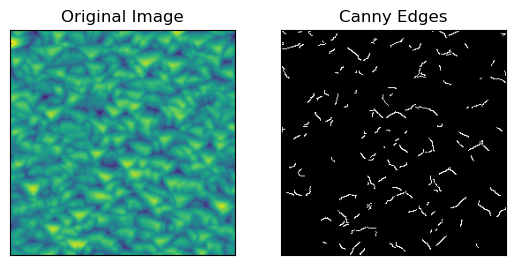

In [6]:
# img = np.copy(w.data[0])

# Normalize the image
image = (img-img.min())/img.ptp() * 256
image = image.astype(np.uint8)
# Apply the Canny edge detector
edges = cv2.Canny(image, 150, 200)  # Adjust the threshold values based on your image

# Display the original image and the edges
plt.subplot(121), plt.imshow(image, cmap='viridis')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Canny Edges'), plt.xticks([]), plt.yticks([])

plt.show()

1823


1823

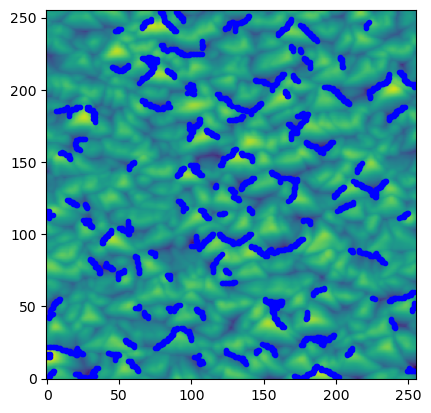

In [7]:
# Adjust the threshold number as needed
y, x = np.where(edges>200)

plt.imshow(img, origin='lower')
plt.plot(x, y, 'b.')
# plt.xlim(0, 50)
# plt.ylim(0, 50)
print(len(x))
len(x)

# Convert the coordinate unit from pixel to distance

In [ ]:
# Here we need a function to convert the pixel coordinates to the distance coordinates 
def convert_coord(obj, img, coord, angle=None):
    '''
    Convert the coordinate from pixel to distance.
    Apply rotation if needed.

    Input:
        obj    - Required: AFMController object
        img    - Required: the image array where coordinates were extracted
        coord  - Required: coordinate pairs in the unit of pixels: [[x0, x1, x2, ...], [y0, y1, y2, ...]]
        angle  - Optional: the rotation angle of the scan. If not provided, angle will be read from the controller.
    Output:
        pos_sorted - Sorted array of coordinate pairs in the physical unit
    '''
    
    x, y = coord
    
    scan_angle = obj.scan_parameters.get_rotation() if angle is None else: angle
    
    # Convert angle to radians
    theta_rad = np.radians(-scan_angle)
    
    # Create 2D rotation matrix
    rot_matrix = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],
                           [np.sin(theta_rad), np.cos(theta_rad)]])
    
    # Apply the rotation matrix to the coordinates
    center = (np.array(np.shape(img))-1) // 2
    x_rot, y_rot = np.zeros_like(x), np.zeros_like(y)
    for i in range(len(x)):
        x_rot[i], y_rot[i] = np.dot(rot_matrix, (np.array([x[i], y[i]])-center)) + center
    
    # Convert the pixels to the distance
    xpixels, ypixels = np.shape(img)
    xsize, ysize = obj.scan_parameters.get_width(), obj.scan_parameters.get_height()

    xfactor = xsize / xpixels
    yfactor = ysize / ypixels

    positions = np.zeros([len(x), 2])

    for i in range(len(x)):
        positions[i] = np.array([x_rot[i] * xfactor, y_rot[i] * yfactor])

    # Sort the positions according to x first and y second
    pos_sorted = sorted(positions, key=lambda x: (x[1], x[0]))
    
    for key in p:
        self.update_param(key=key, value=p[key])
    
    return pos_sorted

In [8]:
pos_sorted = convert_coord(afm, img, coord=[x, y])

# Take force spectrum on the edge points

In [ ]:
# Basically, we move the probe to the positions specified by pos_sorted and take F-D curves (or other 
# spectroscopy)

num_pts = len(pos_sorted[0])

for i in range(num_pts):
    print("Working on Location {}/{}".format(i, num_pts), end='\r')
    
    # Get the next point to measure
    x_next, y_next = pos_sorted[i]

    # Move the probe to the new location
    afm.scan_control.moveX(x_next)
    afm.scan_control.moveY(y_next)

    # Start the F-D curve measurement
    afm.scan_control.do_ramp_absolute_trig()

    # Wait until the spec is done
    time.sleep(10)